In [100]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [101]:
# configuring matplotlib
plt.axes.titlesize : 24
plt.axes.labelsize : 20
plt.figsize = (15, 10)
mpl.style.use('fivethirtyeight')

In [102]:
raw_data =pd.read_csv('../data/raw/dataset.csv', low_memory=False)
raw_data.head()

,maker,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,color_slug,stk_year,transmission,door_count,seat_count,fuel_type,date_created,date_last_seen,price_eur
0,ford,galaxy,151000.0,2011.0,2000.0,103.0,NaN,NaN,None,man,5,7,diesel,2015-11-14 18:10:06.838319+00,2016-01-27 20:40:15.46361+00,10584.75
1,skoda,octavia,143476.0,2012.0,2000.0,81.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.853411+00,2016-01-27 20:40:15.46361+00,8882.31
2,bmw,NaN,97676.0,2010.0,1995.0,85.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.861792+00,2016-01-27 20:40:15.46361+00,12065.06
3,skoda,fabia,111970.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.872313+00,2016-01-27 20:40:15.46361+00,2960.77
4,skoda,fabia,128886.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.880335+00,2016-01-27 20:40:15.46361+00,2738.71


The information regarding different columns is given below:
* maker - The brand 
* model - The model name
* mileage - in KM
* manufacture_year - The year in which the car was manufactured
* engine_displacement - in ccm
* engine_power - in kW
* body_type - almost never present, but I scraped only personal cars, no motorcycles or utility vehicles
* color_slug - also almost never present
* stk_year - year of the last emission control
* transmission - automatic or manual
* door_count -  number of doors in the car
* seat_count - number of seats in the car
* fuel_type - gasoline, diesel, cng, lpg, electric
* date_created - when the ad was scraped
* datelastseen - when the ad was last seen. Our policy was to remove all ads older than 60 days
* price_eur - list price converted to EUR


In [103]:
raw_data.shape

(3552912, 16)

In [104]:
raw_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3552912 entries, 0 to 3552911
Data columns (total 16 columns):
 #   Column               Dtype  
---  ------               -----  
 0   maker                object 
 1   model                object 
 2   mileage              float64
 3   manufacture_year     float64
 4   engine_displacement  float64
 5   engine_power         float64
 6   body_type            object 
 7   color_slug           object 
 8   stk_year             object 
 9   transmission         object 
 10  door_count           object 
 11  seat_count           object 
 12  fuel_type            object 
 13  date_created         object 
 14  date_last_seen       object 
 15  price_eur            float64
dtypes: float64(5), object(11)
memory usage: 433.7+ MB


Let's check the dataframe for missing values in each column

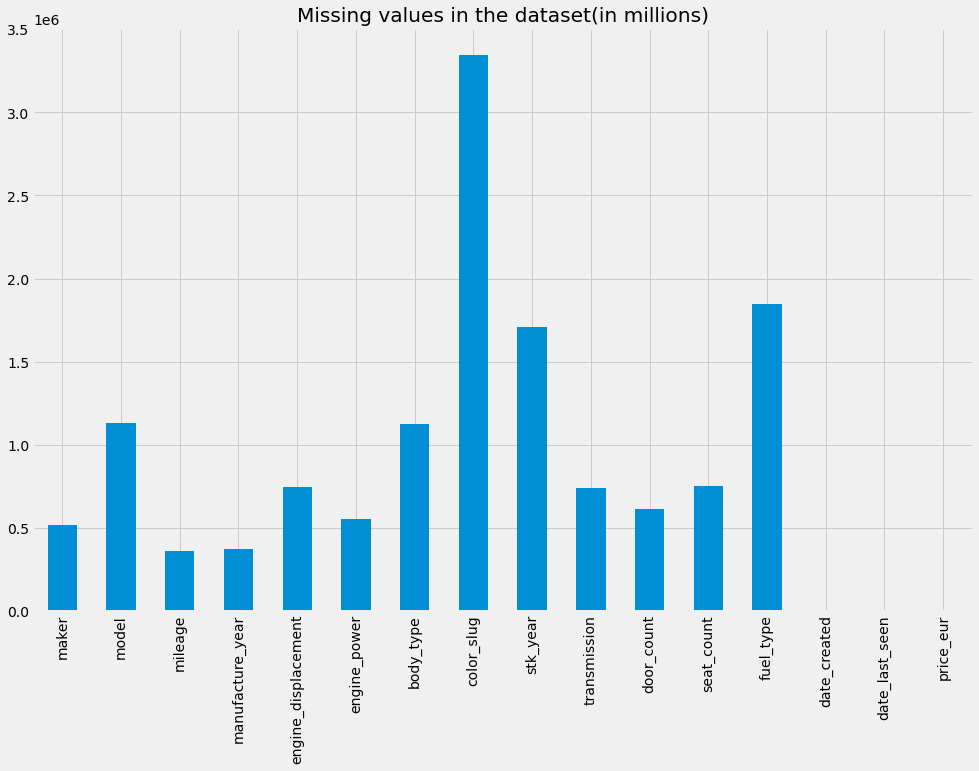

In [105]:
raw_data.isna().sum().plot(x='column names', kind='bar',
                           y='missing values',figsize = plt.figsize, 
                           title='Missing values in the dataset(in millions)', sort_columns=True)

We have a total of `3552912` items in the dataset i.e 3.5 million. Out of those 3.5 millions, `color_slug` is missing almost all of them, `fuel_type` is missing about 1.8 millions, and `stk_year` is missing about 1.7 million.  
Whereas `date_created`, `date_last_seen`, and `price_eur` have no missing values.

# Treating Missing Values

## `color_slug`
---

Almost all values in `color_slug` columns are missing so we can drop it.

In [106]:
raw_data.drop(columns=['color_slug'], inplace=True)
raw_data.columns

Index(['maker', 'model', 'mileage', 'manufacture_year', 'engine_displacement',
       'engine_power', 'body_type', 'stk_year', 'transmission', 'door_count',
       'seat_count', 'fuel_type', 'date_created', 'date_last_seen',
       'price_eur'],
      dtype='object')

## `maker`
---

For the maker we will first find models associated with a maker and use the model to fill the maker name. For example, **Ford** has a car model **galaxy**. If we find that a car with model **galaxy** has missing maker name, we will fill it with **Ford**

In [107]:
grouped_by_maker = raw_data.groupby('maker')
grouped_by_maker

In [108]:
import IPython
methods_for_group = [method_name for method_name in dir(grouped_by_maker)
                    if callable(getattr(grouped_by_maker, method_name)) & ~method_name.startswith("_")]
print(IPython.utils.text.columnize(methods_for_group))

agg        corr      cumsum     get_group  mean     pct_change  sem    transform
aggregate  corrwith  describe   head       median   pipe        shift  tshift   
all        count     diff       hist       min      plot        size   var      
any        cov       expanding  idxmax     ngroup   prod        skew 
apply      cumcount  ffill      idxmin     nth      quantile    std  
backfill   cummax    fillna     last       nunique  rank        sum  
bfill      cummin    filter     mad        ohlc     resample    tail 
boxplot    cumprod   first      max        pad      rolling     take 



In [109]:
#  Lets see if instances with missing maker have a missing model
maker_and_model = raw_data[['model', 'maker']]
model_is_null = maker_and_model[maker_and_model['model'].isnull()].index.tolist()
maker_is_null = maker_and_model[maker_and_model['maker'].isnull()].index.tolist()

In [110]:
# getting item common to both

maker_and_model_are_null = set(model_is_null).intersection(set(maker_is_null))
maker_and_model_are_null = list(maker_and_model_are_null)
len(maker_and_model_are_null)

518915

In [111]:
len(maker_is_null)

518915

From above observation we can see that whenever `model` is null, `maker` is also null. So we cannot use `model` to fill `maker`.

## `door_count`

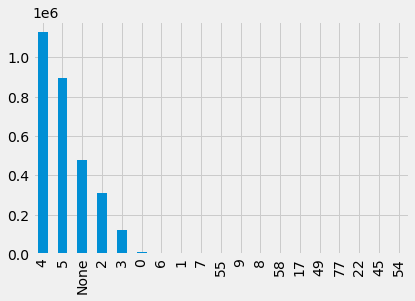

In [112]:
raw_data['door_count'].value_counts().plot(kind='bar')

From above, We can see that most of the cars have 4 door. So we are going to fill missing values in `door_count` with `4`.

In [113]:
# raw_data['door_count'].replace("None", 4, inplace=True)
raw_data['door_count'].fillna(value='4', inplace=True)
raw_data['door_count'].value_counts()

4       1745114
5        894084
None     475693
2        307824
3        120593
0          8010
6          1253
1           273
7            43
55            9
9             4
8             3
58            3
17            1
49            1
77            1
22            1
45            1
54            1
Name: door_count, dtype: int64

In [114]:
# Replacing "None" values with 4
raw_data['door_count'].replace("None", '4', inplace=True)
raw_data['door_count'].value_counts()

4     1745114
5      894084
4      475693
2      307824
3      120593
0        8010
6        1253
1         273
7          43
55          9
9           4
8           3
58          3
49          1
17          1
54          1
77          1
22          1
45          1
Name: door_count, dtype: int64

In [115]:
raw_data['door_count'].isna().sum()

0

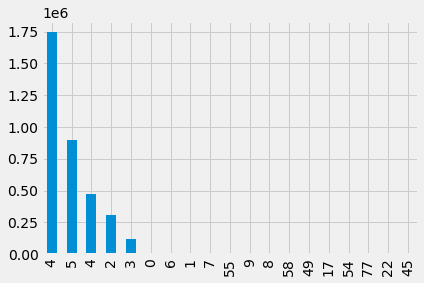

In [116]:
raw_data['door_count'].value_counts().plot(kind='bar')

Have no idea why there are two separate bars for `4` although they are both integers

## `manufacture_year`
Let's have a look at the column `manufacture year` and treat its missing values

In [117]:
raw_data['manufacture_year'].value_counts()

2015.0    441383
2012.0    246152
2011.0    219843
2014.0    201342
2013.0    165305
           ...  
1544.0         1
1549.0         1
1555.0         1
1557.0         1
1553.0         1
Name: manufacture_year, Length: 1640, dtype: int64

Let's check if there is any relation between the model of a car and its manufacture year


In [118]:
manufacture_year_and_make = raw_data[['manufacture_year', 'model']]

In [119]:
manufacture_year_and_make.fillna('None')

,manufacture_year,model
0,2011,galaxy
1,2012,octavia
2,2010,None
3,2004,fabia
4,2004,fabia
...,...,...
3552907,2013,roomster
3552908,2000,felicia
3552909,2006,octavia
3552910,2001,fabia


In [120]:
manufacture_year_and_make.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3552912 entries, 0 to 3552911
Data columns (total 2 columns):
 #   Column            Dtype  
---  ------            -----  
 0   manufacture_year  float64
 1   model             object 
dtypes: float64(1), object(1)
memory usage: 54.2+ MB


In [121]:
manufacture_year_and_make['model'] = manufacture_year_and_make['model'].apply(lambda x: str(x))

/Users/bhuwanbhatt/Documents/neuralnet/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [122]:
# # encoding model of the car as a numerical variable
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
manufacture_year_and_make["model_encoded"] = lb_make.fit_transform(manufacture_year_and_make["model"].values)

manufacture_year_and_make.head()

# correlation = manufacture_year_and_make.corr()

/Users/bhuwanbhatt/Documents/neuralnet/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,manufacture_year,model,model_encoded
0,2011.0,galaxy,484
1,2012.0,octavia,680
2,2010.0,nan,667
3,2004.0,fabia,450
4,2004.0,fabia,450


To be continued


In [123]:
correlation = manufacture_year_and_make.corr()
correlation

,manufacture_year,model_encoded
manufacture_year,1.000000,0.001674
model_encoded,0.001674,1.000000


There is low correlation so we cannot use model to fill in manufacture_year

## `transmission`

In [124]:
raw_data['transmission'].value_counts()

man     2021990
auto     789292
Name: transmission, dtype: int64

In [125]:
raw_data['transmission'].isna().sum()

741630

Ideally there should be a high correlatio between transmission type and model. Let's check it out

In [126]:
# # encoding model of the car as a numerical variable
transmission_and_model = raw_data[['transmission', 'model']]
transmission_and_model['model'] = transmission_and_model['model'].apply(lambda x: str(x))
transmission_and_model['transmission'] = transmission_and_model['transmission'].apply(lambda x: str(x))

lb_make = LabelEncoder()
transmission_and_model["model_encoded"] = lb_make.fit_transform(transmission_and_model["model"])
transmission_and_model["transmission_encoded"] = lb_make.fit_transform(transmission_and_model["transmission"])

correlation = transmission_and_model.corr()
correlation

/Users/bhuwanbhatt/Documents/neuralnet/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/bhuwanbhatt/Documents/neuralnet/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/bhuwanbhatt/Documents/neuralnet/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A

,model_encoded,transmission_encoded
model_encoded,1.00000,-0.05526
transmission_encoded,-0.05526,1.00000


This doesn't feel right but let it be

## `seat_count`
---

In [127]:
raw_data['seat_count'].value_counts()

5       1767868
None     537610
4        244797
7        100744
2         72685
3         33607
6         14174
9         12575
0         11695
8          6754
1           567
17           39
10           35
12           31
15           19
14           19
18           16
19           14
20           13
45           13
21           13
23           13
13           10
16            9
50            9
11            8
55            8
57            7
51            7
58            6
56            5
54            4
25            4
24            3
29            3
53            3
52            3
36            3
81            3
32            2
44            2
74            2
30            2
33            2
49            2
512           2
27            2
515           1
138           1
517           1
65            1
255           1
85            1
43            1
61            1
26            1
22            1
59            1
Name: seat_count, dtype: int64

In [128]:
# Fill 'None' with the most frequent value i.e 5.
raw_data['seat_count'].replace("None", '5', inplace=True)
# Now lets check for null values
raw_data['seat_count'].isna().sum()

749489

In [129]:
# Looking at a particular model
grouped_by_model = raw_data.groupby('model')
grouped_by_model.get_group('fabia')['seat_count'].unique()

array(['5', '4', '2', '3', '56', '7', '1', nan, '6', '9', '8', '0'],
      dtype=object)

'0' is not possible. 

In [130]:
grouped_by_model.get_group('fabia')['seat_count'].value_counts()

5     60537
4       949
0       612
6        18
2        18
7         5
3         3
1         2
9         2
56        1
8         1
Name: seat_count, dtype: int64

In [133]:
grouped_by_model.get_group('fabia')['seat_count'].mode()

0    5
dtype: object

In [134]:
grouped_by_model.get_group('galaxy')['seat_count'].value_counts()

7    4951
5    3100
6     323
0      12
2       6
4       4
3       3
8       2
Name: seat_count, dtype: int64

In [135]:
grouped_by_model.get_group('octavia')['seat_count'].value_counts()

5     83090
0      1272
4       320
6        47
2        19
7         6
8         5
3         4
9         3
1         1
50        1
54        1
Name: seat_count, dtype: int64

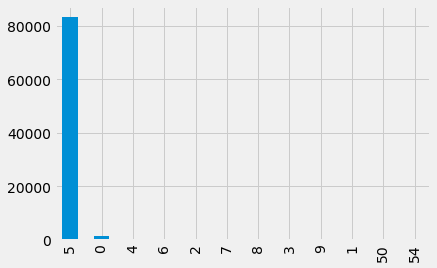

In [137]:
grouped_by_model.get_group('octavia')['seat_count'].value_counts().plot(kind='bar')